# PGGAN for MNIST

### Left to do
- Implement progressive training
- Implement a fade procedure

## Imports

In [1]:
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

from generators import PGGenerator
from discriminators import PGDiscriminator
from utils import img2vec,vec2img,sample_noise,true_target,fake_target

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Dataset loading

In [2]:
compose = transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
dataset = datasets.MNIST(root='MNIST',train=True,transform=compose,download=True)

### Input scaling

In [3]:
def scale_to_res(x,res):
    batch_size = x.size(0)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=int(res),interpolation=0),# 0: nearest
        transforms.ToTensor()
    ])
    x_0 = torch.zeros(batch_size,x.size(1),res,res)
    for i in range(batch_size):
        x_0[i] = transform(x[i])
    return x_0.to(device)

### WGAN-GP: gradients penalty

In [4]:
LAMBDA = 10 # recommended value from the original paper

def calc_gradient_penalty(discriminator,real_data,fake_data,current_alpha):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size,1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device) 
    
    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = autograd.Variable(interpolates,requires_grad=True)
    interpolates = interpolates.to(device)
    
    disc_interpolates = discriminator(vec2img(interpolates,image_size),current_alpha).view(-1)

    gradients = autograd.grad(outputs=disc_interpolates,inputs=interpolates,
                              grad_outputs=torch.ones(batch_size).to(device),
                              create_graph=True,retain_graph=True,only_inputs=True)[0]
    gradient_penalty = ((gradients.norm(p=2,dim=1)-1)**2).mean()*LAMBDA
    return gradient_penalty

## Training setup

In [5]:
batch_size = 128
m = int(np.sqrt(batch_size))-1 # the sqrt of number of test samples

lr = 1e-3
dropout_prob = 0.2

noise_dim = 32
output_size = 1

clipping_value = 1e-2

image_size = 4

max_blocks = 5

num_test_samples = m**2
test_noise = sample_noise(num_test_samples,noise_dim,device)[:,:,None,None]

# intialize models
generator = PGGenerator(input_size=noise_dim,output_size=output_size).to(device)
discriminator = PGDiscriminator(input_size=output_size,hidden_size=32).to(device)

# optimizers
g_optimizer = optim.Adam(generator.parameters(),lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(),lr=lr)

# data loader
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error"])
# Total number of epochs to train
num_epochs = 100
global_step = 0
epoch = 0
d_error = 0
g_error = 0

### Train Generator

In [6]:
def train_generator(noise,optimizer,current_alpha):
    '''
    Train the generator to generate realistic samples and thereby fool the discriminator
    '''
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(noise,current_alpha)
    loss = - torch.mean(prediction)
    loss.backward()
    optimizer.step()
    return loss

### Train Discriminator

In [7]:
def train_discriminator(real_data,fake_data,optimizer,current_alpha):
    '''
    Train the discriminator to distinguish between real and fake data
    '''
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    batch_size = real_data.size(0)
    penalty = calc_gradient_penalty(discriminator,real_data.view(batch_size,-1),fake_data.view(batch_size,-1),current_alpha)
    loss = prediction_fake.mean() - prediction_real.mean() + penalty
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
    
    return loss

## Train the model

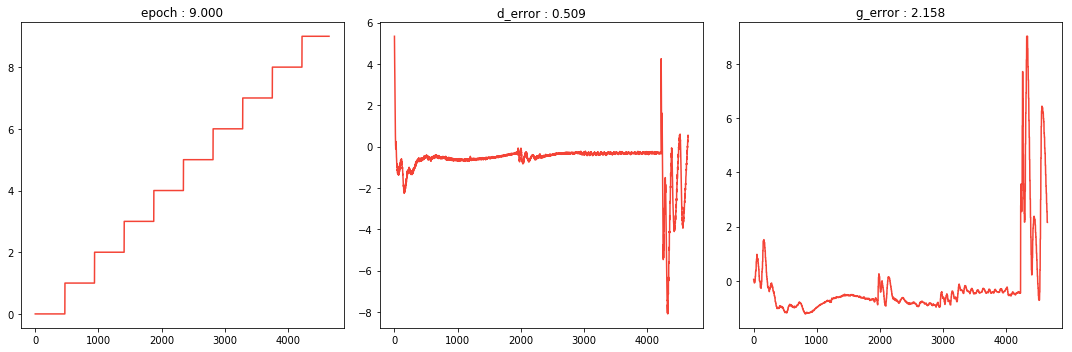

<Figure size 432x288 with 0 Axes>

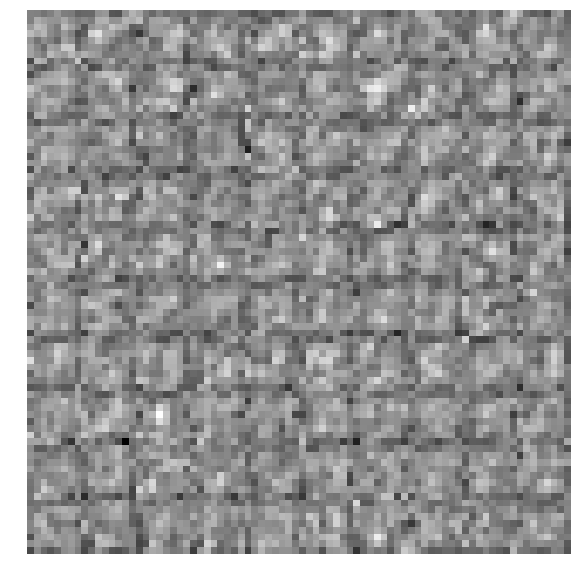

RuntimeError: Given groups=1, weight[64, 32, 3, 3], so expected input[100, 64, 8, 8] to have 32 channels, but got 64 channels instead

In [8]:
gen_steps = 1
gen_train_freq = 5
fade = 0
fade_freq = 10
alpha = torch.linspace(0,1,steps=fade_freq)
num_blocks = 1

try:
    while epoch < num_epochs:
        if (epoch+1) % fade_freq == 0:
            # switch fade status
            fade = 0 if (fade or num_blocks >= max_blocks) else 1
            if fade:
                # update image_size
                image_size *= 2
                # update models
                generator.create_next_block(generator.input_size*2)
                discriminator.create_next_block(discriminator.block_output_size*2)
                generator.to(device)
                discriminator.to(device)
                # update optimizers
                g_optimizer = optim.Adam(generator.parameters(),lr=lr)
                d_optimizer = optim.Adam(discriminator.parameters(),lr=lr)
                num_blocks += 1
                print("Number of blocks changed to {}".format(num_blocks))
        # find the current alpha value, and only use it if fade is true
        if fade:
            current_alpha = alpha[epoch%fade_freq]
        else:
            current_alpha = 1.0
        for n_batch,(real_batch,_) in enumerate(data_loader):
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_data = scale_to_res(real_batch,image_size).to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = sample_noise(N,noise_dim,device)[:,:,None,None]
            with torch.no_grad():
                fake_data = generator(noise_tensor,current_alpha).detach()
            # Train D
            d_error = train_discriminator(real_data,fake_data,d_optimizer,current_alpha)

            # 2. Train Generator every 'gen_train_freq' steps
            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # Generate fake data
                    fake_data = generator(sample_noise(N,noise_dim,device)[:,:,None,None],current_alpha)
                    # Train G
                    g_error = train_generator(fake_data,g_optimizer,current_alpha)
                    g_error = g_error.item()

            # Log batch error and delete tensors
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error} )
            global_step += 1
            del fake_data
            del real_data
            del noise_tensor

            # Display Progress every few batches
            if global_step % 50 == 0:
                test_images = vec2img(generator(test_noise,current_alpha),image_size)
                test_images = test_images.data
                canvas = np.zeros((image_size*m,image_size*m))
                q = 0
                for i in range(m):
                    for j in range(m):
                        canvas[i*image_size:(i+1)*image_size,j*image_size:(j+1)*image_size] = test_images[q]
                        q += 1
                dis.display(scale=False)
                plt.figure(figsize=(10,10))
                plt.imshow(canvas,cmap='gray')
                plt.axis("off")
                if epoch % 50 == 0:
                    plt.savefig("Figures/PGGAN-MNIST-Epoch="+str(epoch)+".png")
                plt.show()
        epoch += 1
except:
    test_images = vec2img(generator(test_noise,current_alpha),image_size)
    test_images = test_images.data
    canvas = np.zeros((image_size*m,image_size*m))
    q = 0
    for i in range(m):
        for j in range(m):
            canvas[i*image_size:(i+1)*image_size,j*image_size:(j+1)*image_size] = test_images[q]
            q+=1
    dis.display(scale=False)
    plt.figure(figsize=(10,10))
    plt.imshow(canvas,cmap='gray')
    plt.axis("off")
    plt.savefig("Figures/PGGAN-MNIST.png")
    plt.show()